# Face Detection

* Author: Johannes Maucher
* Last update: 04.06.2020

In [1]:
#!pip install opencv-python

In [2]:
import cv2
from matplotlib import pyplot as plt

## Apply Viola-Jones Face Detection

Viola-Jones algorithm is a machine learning based approach for detecting and localising faces in images. For a detailed description of the algorithm see for example [J. Maucher: Object Recognition Lecture](https://gitlab.mi.hdm-stuttgart.de/maucher/or/-/blob/master/Slides/V06DetectionWindowBased.pdf).
OpenCV provides an already trained Viola-Jones algorithm for face detection. The pre-trained model is available as a .xml - file, which must be downloaded from here: [haarcascade_frontalface_default.xml](https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml)
If you saved this file to your current directory, the trained classifier-object can be created as follows:

In [3]:
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

### Load and display image

In [4]:
filename='hicham.jpg'

In [5]:
#inputimage = cv2.imread('Gruender.jpg')
inputimage = cv2.imread('hicham.jpg')
inputimage = cv2.cvtColor(inputimage,cv2.COLOR_BGR2RGB)

In [6]:
inputimage.shape

(488, 894, 3)

In [7]:
img=inputimage.copy()

### Apply pretrained algorithm to find faces
The classifier-object created above provides the `detectMultiScale2(image,scaleFactor,minNeighbors)`-method. This method localises the faces in `image`. 
 
The `scaleFactor`-argument controls how the input image is scaled prior to detection, e.g. is it scaled up or down, which can help to better find the faces in the image. The default value is 1.1 (10% increase).

The `minNeighbors`-argument determines how robust each detection must be in order to be reported, e.g. the number of candidate rectangles that found the face. The default is 3, but this can be lowered to 1 to detect a lot more faces and will likely increase the false positives.

The method returns for each of the detected faces the x- and y- coordinate and the width and height of the face's bounding box.

In [8]:
bboxes = classifier.detectMultiScale2(img,scaleFactor=1.2,minNeighbors=3)

Next, the detected bounding boxes are drawn into the image:

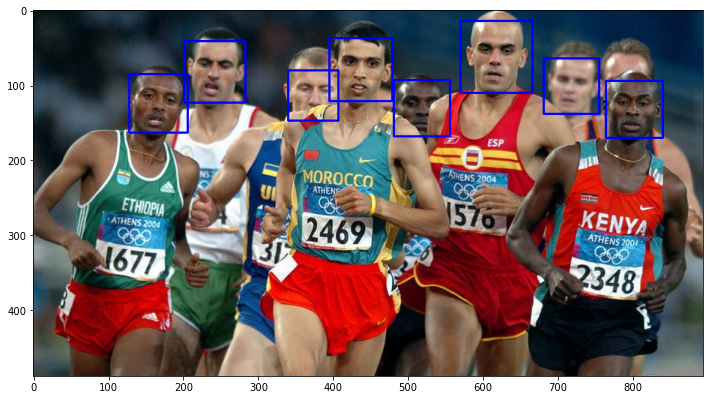

In [9]:
plt.figure(figsize=(12,10))
for box in bboxes[0]:
    x, y, width, height = box
    x2, y2 = x + width, y + height
    cv2.rectangle(img, pt1=(x, y), pt2=(x2, y2), color=(0,0,255), thickness=2)
    plt.imshow(img)
plt.show()

## Deep Learning based Face Detection

There exist different deep learning architectures for face detection, e.g. the [Multi-Task Cascaded Convolutional Neural Network (MTCNN)](https://arxiv.org/abs/1604.02878).

A MTCNN package, based on Tensorflow and opencv, which already contains a pretrained model can be installed as follows:   

### Overall approach
The approach, proposed in [Multi-Task Cascaded Convolutional Neural Network (MTCNN)](https://arxiv.org/abs/1604.02878) consists of 4 stages, which are sketched in the picture below:

1. **Stage 1:** In order to achieve scale-invariance, a pyramid of the test-image is generated. This pyramid of images is the input of the following stages.
2. **Stage 2:** In this stage a fully convolutional network, called Proposal Network (P-Net), is applied to calculate the candidate windows and their bounding box regression vectors. The estimated bounding box regression vectors are then applied to calibrate the candidates. Finally, non-maximum suppression (NMS) is applied to merge highly overlapping candidates. P-Net is fast, but produces a lot false-positives.
3. **Stage 3:** All candidates (i.e. positives and false positives) are fed to another CNN, called Refine Network (R-Net), which further rejects a large number of false candidates, performs calibration with bounding box regression, and NMS candidate merge
4. **Stage 4:** This stage is similar to the second stage, but in this stage the goal is to describe the face in more details. In particular, the network will output five facial landmarks’ positions


<img src="https://maucher.home.hdm-stuttgart.de/Pics/mtcnnStages.png" alt="Drawing" style="width: 500px;"/>

Source: [Multi-Task Cascaded Convolutional Neural Network (MTCNN)](https://arxiv.org/abs/1604.02878)

### Architecture of 3 CNNs
**P-Net interpretation as fully convolutional net:** Densely scanning an image of size $W × H$ for $12 × 12$ detection windows with a stepsize of 4 is equivalent to apply the entire net to the whole image to obtain a $(⌊(W − 12)/4⌋ + 1) × (⌊(H − 12)/4⌋ + 1)$ map of confidence scores. Each point on the confidence map refers to a $12 × 12$ detection window on the testing image.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/mtcnnArchitecture.png" alt="Drawing" style="width: 800px;"/>

Source: [Multi-Task Cascaded Convolutional Neural Network (MTCNN)](https://arxiv.org/abs/1604.02878)

### Training

Since **face detection** and **alignment** is performed jointly, different annotation types for training-data is required:
* **Negatives:** Regions with an Intersection-over-Union (IoU) ratio less than 0.3 to any ground-truth face,
* **Positives:** IoU above 0.65 to a ground truth face;
* **Part faces:** IoU between 0.4 and 0.65 to a ground truth face; 
* **Landmark faces:** faces labeled 5 landmarks’ positions. 

Negatives and positives are used for the **face classification task**. Positives and part faces are used for **bounding box regression**. Landmark faces are used for **facial landmark localization**.

The picture below depicts the determination of **Positives** from labeled training data. In the original size of the image only one of the $(12 x 12)$ windows is annotated as positive, since it's IoU with a ground-truth bounding box exceeds a defined threshold $T$. In the next smaller image-version two $(12 x 12)$ windows are annotated as positive and in the smallest version another positive candidate is found. Note that to each of the found Positives and Part faces, the corresponding ground-truth bounding-box is assigned.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/IoUpositives.png" alt="Drawing" style="width: 400px;"/>

The authors of [Multi-Task Cascaded Convolutional Neural Network (MTCNN)](https://arxiv.org/abs/1604.02878) applied the [WIDER FACE benchmark](http://shuoyang1213.me/WIDERFACE/) to annotate Positives, Negatives and Part faces. For landmark annotations the [CelebA benchmark](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) has been applied.

For the **face classification task training** the binary cross-entropy is minimized. Each sample $x_i$ (detection window) contributes by

$$
L_i^{det}= - (y_i^{det} \log(p_i) + (1-y_i^{det}) \log(1-p_i)),
$$

where $p_i$ is the probability produced by the network that indicates that $x_i$ is a Positive. The notation $y_i^{det}$ denotes the ground-truth label of $x_i$.

For the **bounding box regression training** the mean-squared-error (MSE) between the 4-coordinates $(x,y,w,h)$ of the true and the estimated bounding-box is minimized. Each candidate window contributes by

$$
L_i^{box}=|| \hat{y}_i^{box} - y_i^{box} ||_2 ,
$$

where $\hat{y}_i^{box}$ is the bounding box, estimated by the network and $y_i{box}$ is the corresponding ground-truth box. $|| x ||_2$ is the $L_2$-norm of $x$. 

For the **facial landmark training** also the mean-squared-error (MSE) between the 10-coordinates ($(x,y)$ of 5 facial landmarks) of the true and the estimated landmarks is minimized. Each candidate contributes by

$$
L_i^{landmark}=|| \hat{y}_i^{landmark} - y_i^{landmark} ||_2 ,
$$

where $\hat{y}_i^{landmark}$ is the 10-dimensional landmark vector, estimated by the network and $y_i^{landmark}$ is the vector describing the true positions of the 5 landmarks. 

The **overall loss-function** is then

$$
L = \sum\limits_{i=1}^N \sum\limits_{j \in \{det,box,landmark\}} \alpha_j \beta_i^j L_i^j,
$$

where $ \beta_i^j \in \{0,1\}$ is the sample-type indicator (1 if i.th sample belongs to training set of task j, else 0). In the paper $\alpha_{det}=1, \alpha_{box}=0.5, \alpha_{landmark}=0.5$ have been applied to train P- and R-Net, and $\alpha_{det}=1, \alpha_{box}=0.5, \alpha_{landmark}=1$ for O-Net. The overall loss-function has been minimized by Stochastic-Gradient-Descent.

### Sketches for Training and Inference

<img src="https://maucher.home.hdm-stuttgart.de/Pics/mtcnnTraining.png" alt="Drawing" style="width: 700px;"/>

<img src="https://maucher.home.hdm-stuttgart.de/Pics/mtcnnInference.png" alt="Drawing" style="width: 650px;"/>

In [10]:
#!pip install mtcnn

### Apply pretrained MTCNN for face detection and facial landmark detection
In the following code-cell first a MTCNN-object is created. Then this object's `detect_faces()`-method is invoked in order to detect the faces and the facial landmarks

In [11]:
img2=inputimage.copy()

In [12]:
from mtcnn.mtcnn import MTCNN

detector = MTCNN()
faces = detector.detect_faces(img2)

As can be seen in the following output, for each face the bounding-box coordinates, the confidence and the positions of the facial landmarks are specified:

In [13]:
for face in faces:
    print(face)

{'box': [133, 83, 62, 89], 'confidence': 0.9999963045120239, 'keypoints': {'left_eye': (155, 114), 'right_eye': (183, 119), 'nose': (168, 128), 'mouth_left': (152, 145), 'mouth_right': (176, 149)}}
{'box': [212, 38, 59, 85], 'confidence': 0.999977707862854, 'keypoints': {'left_eye': (230, 71), 'right_eye': (255, 74), 'nose': (241, 88), 'mouth_left': (228, 101), 'mouth_right': (249, 104)}}
{'box': [405, 38, 62, 82], 'confidence': 0.9999536275863647, 'keypoints': {'left_eye': (424, 69), 'right_eye': (452, 71), 'nose': (436, 87), 'mouth_left': (423, 101), 'mouth_right': (446, 103)}}
{'box': [771, 95, 56, 75], 'confidence': 0.9999328851699829, 'keypoints': {'left_eye': (788, 123), 'right_eye': (814, 125), 'nose': (801, 137), 'mouth_left': (788, 154), 'mouth_right': (809, 155)}}
{'box': [490, 96, 53, 69], 'confidence': 0.9998329877853394, 'keypoints': {'left_eye': (506, 123), 'right_eye': (531, 121), 'nose': (519, 136), 'mouth_left': (509, 150), 'mouth_right': (529, 149)}}
{'box': [691, 67,

Next, the detected bounding-boxes are plotted into the image:

In [14]:
# draw an image with detected objects
def draw_image_with_boxes(image, result_list):
    # load the image
    #data = plt.imread(filename)
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        for key, value in result['keypoints'].items():
            # create and draw dot
            dot = Circle(value, radius=2, color='red')
            ax.add_patch(dot)
    # show the plot
    plt.show()

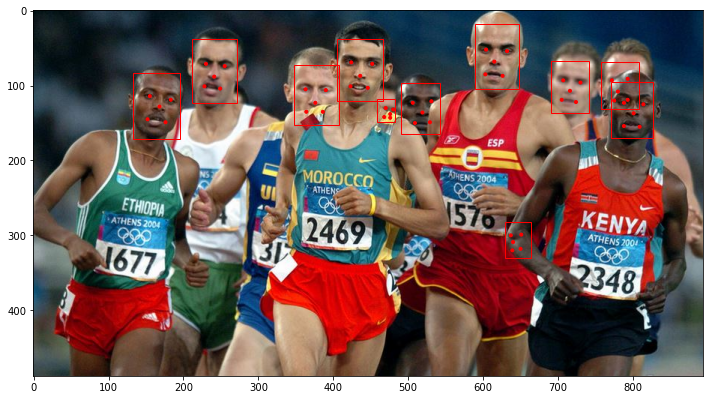

In [15]:
from matplotlib.patches import Rectangle,Circle
plt.figure(figsize=(12,10))
detector = MTCNN()
faces = detector.detect_faces(img2)
draw_image_with_boxes(img2, faces)

In [16]:
# draw each face separately
def draw_faces(image, result_list):
    
    plt.figure(figsize=(16,10))
    for i in range(len(result_list)):
        # get coordinates
        x1, y1, width, height = result_list[i]['box']
        x2, y2 = x1 + width, y1 + height
        # define subplot
        plt.subplot(1, len(result_list), i+1)
        plt.axis('off')
        # plot face
        plt.imshow(image[y1:y2, x1:x2])
    # show the plot
    plt.show()

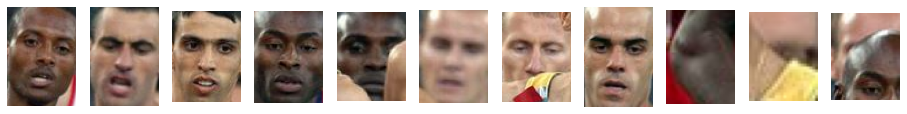

In [17]:
draw_faces(img2, faces)